# Analysis of Q2 on the Maven Dependency Graph (MDG)

This document is the second chapter of a set of notebooks that accompany the paper "Breaking Bad? Semantic Versioning and Impact of Breaking Changes in Maven Central". In this chapter, we investigate Q2 and its corresponding null hypothesis on the Maven Dependency Graph (MDG).

**Q2**: To what extent has the adherence to semantic versioning principles increased
over time??

**H$_2$**: The adherence to semantic versioning principles has increased over time.

**Note**: To have access to the Exploratory Data Analysis of the dataset, please refer to the notebook Q1-MDG.

---

## Table of Contents
<div class="toc" style="margin-top: 1em;">
    <ul class="toc-item">
        <li>
            <span><a href="#Setup" data-toc-modified-id="Setup">Setup</a></span>
        </li>
        <li>
            <span><a href="#Dataset" data-toc-modified-id="Dataset">Dataset</a></span>
            <ul class="toc-item">
                <li>
                    <span><a href="#Load-Dataset" data-toc-modified-id="Load-Dataset">Load Dataset</a></span>
                </li>
                <li>
                    <span><a href="#Clean-Dataset" data-toc-modified-id="Clean-Dataset">Clean Dataset</a></span>
                </li>
                <li>
                    <span><a href="#Finalize-Dataset" data-toc-modified-id="Finalize-Dataset">Finalize Dataset</a></span>
                </li>
            </ul>
        </li>
        <li>
            <span><a href="#Dataset-Summary" data-toc-modified-id="Dataset-Summary">Dataset Summary</a></span>
        </li>
        <li>
            <span><a href="#Results" data-toc-modified-id="Results">Results</a></span>
            <ul class="toc-item">
                <li>
                    <span><a href="#Data-Preparation" data-toc-modified-id="Data-Preparation">Data Preparation</a></span>
                </li>
                <li>
                    <span><a href="#Histograms" data-toc-modified-id="Histograms">Histograms</a></span>
                </li>
                <li>
                    <span><a href="#Line-Plot" data-toc-modified-id="Line-Plot">Line Plot</a></span>
                </li>
            </ul>
        </li>
        <li>
            <span><a href="#EOF" data-toc-modified-id="EOF">EOF</a></span>
        </li>
    </ul>
</div>

---

## Setup

In [1]:
# Import required libraries
library(ggplot2)
library(tidyverse)
library(gridExtra)
library(ggthemes)

# Set theme
theme_set(theme_stata())

Warning message:
“package ‘ggplot2’ was built under R version 3.5.2”
Warning message:
“package ‘tidyverse’ was built under R version 3.5.2”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
✔ purrr   0.3.3     

Warning message:
“package ‘tidyr’ was built under R version 3.5.2”
Warning message:
“package ‘purrr’ was built under R version 3.5.2”
Warning message:
“package ‘stringr’ was built under R version 3.5.2”
Warning message:
“package ‘forcats’ was built under R version 3.5.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Warning message:
“package ‘ggthemes’ was built under R version 3.5.2”


---

## Dataset

### Load Dataset

First, we load the `deltas.csv` dataset which contains information about breaking changes computed by Maracas on the selected upgrades of the MDG.

In [2]:
deltas <- read.csv("../code/cypher-queries/data/gen/deltas.csv", stringsAsFactors=FALSE, colClasses=c("level"="factor", "year"="factor", "java_version_v1"="factor", "java_version_v2"="factor", "expected_level"="factor"))
sprintf("Successfully loaded %d deltas", nrow(deltas))
head(deltas)

[1] "Successfully loaded 163814 deltas"

,group,artifact,v1,v2,level,language,year,age_diff,distance,clients,⋯,fieldLessAccessible_unstableAnnon,fieldMoreAccessible_unstableAnnon,constructorRemoved_unstableAnnon,constructorLessAccessible_unstableAnnon,unstableAnnons,jar_v1,jar_v2,delta,exception,t
,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<fct>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
1,commons-lang,commons-lang,2.3,2.4,MINOR,java,2008,1,5,1672,⋯,-1,-1,-1,-1,{},-1,-1,-1,invalid-java-version,1
2,commons-lang,commons-lang,2.6,3.4,MAJOR,unknown,2016,1,24,47300,⋯,-1,-1,-1,-1,{},-1,-1,-1,jar-not-found,1
3,commons-collections,commons-collections,3.2,3.2.0,PATCH,unknown,2016,1,18,3556,⋯,-1,-1,-1,-1,{},-1,-1,-1,jar-not-found,1
4,commons-lang,commons-lang,2.1,2.2,MINOR,java,2006,1,14,1359,⋯,-1,-1,-1,-1,{},-1,-1,-1,invalid-java-version,1
5,commons-collections,commons-collections,3.0,3.1,MINOR,java,2005,1,0,153,⋯,-1,-1,-1,-1,{},-1,-1,-1,invalid-java-version,1
6,commons-lang,commons-lang,2.0,2.1,MINOR,java,2005,1,0,280,⋯,-1,-1,-1,-1,{},-1,-1,-1,invalid-java-version,1


### Clean Dataset

Here, we clean the dataset to discard the upgrades and deltas not complying with our requirements.

In [3]:
# What issues did we encounter when attempting to compute the deltas? (Java version >= 8, JAR not produced from Java code, JAR not found on Maven Central, etc.)
table(deltas$exception)


                  -1     exception-raised invalid-java-version 
              122913                  271                  852 
    invalid-language        jar-not-found 
               29190                10588 

In [4]:
# Which languages did we find?
table(deltas$language)


clojure  groovy    java  kotlin   scala unknown 
     20    1137  123828    1359   14402   23068 

In [5]:
# Discard all deltas that raised an exception
deltas <- subset(deltas, exception == -1)

# Discard all deltas for upgrades that do not contain any code
sprintf("%d deltas correspond to JARs not containing any code", nrow(subset(deltas, declarations_v1 == 0 & declarations_v2 == 0)))
deltas <- subset(deltas, declarations_v1 > 0 | declarations_v2 > 0)

# Discard all deltas where v1 was released _after_ v2
sprintf("%d where v1 was released after v2", nrow(subset(deltas, age_diff < 0)))
deltas <- subset(deltas, age_diff >= 0)

sprintf("%d remaining deltas after cleaning", nrow(deltas))

[1] "0 deltas correspond to JARs not containing any code"

[1] "2929 where v1 was released after v2"

[1] "119984 remaining deltas after cleaning"

In [6]:
# Remove cases where dates are used as versions (e.g. 20081010.0.1, 1.20081010.1, 1.0.20081010)
deltas <- deltas[grep("^[0-9]{0,7}[.][0-9]{0,7}([.][0-9]{0,7})?$", deltas$v1),]
deltas <- deltas[grep("^[0-9]{0,7}[.][0-9]{0,7}([.][0-9]{0,7})?$", deltas$v2),]

deltas <- deltas[!grepl("^2[0-9]{3}[.][0-9]{2}([.][0-9]{2})?$", deltas$v1),]
deltas <- deltas[!grepl("^[0-9]{2}[.][0-9]{2}[.]2[0-9]{3}$", deltas$v1),]
deltas <- deltas[!grepl("^[0-9]{2}[.]2[0-9]{3}$", deltas$v1),]

deltas <- deltas[!grepl("^2[0-9]{3}[.][0-9]{2}([.][0-9]{2})?$", deltas$v2),]
deltas <- deltas[!grepl("^[0-9]{2}[.][0-9]{2}[.]2[0-9]{3}$", deltas$v2),]
deltas <- deltas[!grepl("^[0-9]{2}[.]2[0-9]{3}$", deltas$v2),]

sprintf("%d deltas remaining after removing the ones with dates as versions", nrow(deltas))

[1] "119879 deltas remaining after removing the ones with dates as versions"

### Finalize Dataset
Here, we incorporate additional derived information into the dataset.

In [7]:
# Add column with all BCs excluding the ones related to: 
# - annotationDeprecatedAdded: not a BC
# - methodAddedToPublicClass: not a BC
# - classNowCheckedException: not binary incompatible
# - methodNowThrowsCheckedException: not binary incompatible
# - fieldStaticAndOverridesStatic: lack of alignment with JLS
# - superclassModifiedIncompatible: lack of alignment with JLS
# - methodIsStaticAndOverridesNotStatic: lack of alignment with JLS
# - methodAbstractAddedInSuperclass: covered by other BC
# - methodAbstractAddedInImplementedInterface: covered by other BC
# - methodLessAccessibleThanInSuperclass: covered by other BC
# - fieldLessAccessibleThanInSuperclass: covered by other BC
# - fieldRemovedInSuperclass: covered by other BC
# - methodRemovedInSuperclass: covered by other BC

deltas$bcs_clean = deltas$bcs -
    deltas$annotationDeprecatedAdded -
    deltas$methodAddedToPublicClass - 
    deltas$classNowCheckedException - 
    deltas$methodNowThrowsCheckedException -
    deltas$fieldStaticAndOverridesStatic -
    deltas$superclassModifiedIncompatible - 
    deltas$methodIsStaticAndOverridesNotStatic -
    deltas$methodAbstractAddedInSuperclass -
    deltas$methodAbstractAddedInImplementedInterface -
    deltas$methodLessAccessibleThanInSuperclass - 
    deltas$fieldLessAccessibleThanInSuperclass -
    deltas$fieldRemovedInSuperclass -
    deltas$methodRemovedInSuperclass

# Same thing for the stable part of the API
deltas$bcs_clean_stable = deltas$bcs_stable -
    deltas$annotationDeprecatedAdded_stable -
    deltas$methodAddedToPublicClass_stable - 
    deltas$classNowCheckedException_stable - 
    deltas$methodNowThrowsCheckedException_stable -
    deltas$fieldStaticAndOverridesStatic_stable -
    deltas$superclassModifiedIncompatible_stable - 
    deltas$methodIsStaticAndOverridesNotStatic_stable -
    deltas$methodAbstractAddedInSuperclass_stable -
    deltas$methodAbstractAddedInImplementedInterface_stable -
    deltas$methodLessAccessibleThanInSuperclass_stable - 
    deltas$fieldLessAccessibleThanInSuperclass_stable -
    deltas$fieldRemovedInSuperclass_stable -
    deltas$methodRemovedInSuperclass_stable

In [8]:
# Add columns with BCs ratios (i.e. BCs / V1 declarations)
deltas$bcs_ratio_clean = deltas$bcs_clean / deltas$declarations_v1
deltas$bcs_ratio_clean_stable = deltas$bcs_clean_stable / deltas$declarations_v1

In [9]:
# Assign the 'DEV' semver level to versions of the form 0.x.x
levels(deltas$level) <- c(levels(deltas$level), "DEV")
deltas[grepl("^0[.]", deltas$v1),]$level = "DEV"

---

## Dataset Summary

In [10]:
sprintf("Final size of the dataset: %s deltas", nrow(deltas))
#summary(deltas)

[1] "Final size of the dataset: 119879 deltas"

---

## Results

### Data Preparation

In [11]:
# Get all years
years <- sort(unique(deltas$year))
years

[1] 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018
15 Levels: 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 ... 2018

In [12]:
# Computes the percentage of breaking upgrades per semver level
perc_breaking_upgrades <- function(ds, dat, semver_level) {
    dt <- subset(ds, level == semver_level)
    
    for (y in years) {
        dt_current <- subset(dt, year == y)
        val <- 0.0
        
        if (nrow(dt_current) != 0) {
            val <- nrow(subset(dt_current, bcs_clean_stable > 0)) / nrow(dt_current)
        }
        dat <- rbind(dat, data.frame(year=y, level=semver_level, breaking=val))
    }
    
    return (dat)
}

In [13]:
# Computing percentage of breaking upgrades per semver level per year
breaking_upgrades <- data.frame(
    year=character(),
    level=character(),
    breaking=double()
)

breaking_upgrades <- perc_breaking_upgrades(deltas, breaking_upgrades, "MAJOR")
breaking_upgrades <- perc_breaking_upgrades(deltas, breaking_upgrades, "MINOR")
breaking_upgrades <- perc_breaking_upgrades(deltas, breaking_upgrades, "PATCH")
breaking_upgrades <- perc_breaking_upgrades(deltas, breaking_upgrades, "DEV")

# Extend results with non-major cases
dt2 <- deltas
dt2$level <- as.character(dt2$level)
dt2[dt2$level == "MINOR" || dt2$level == "PATCH",]$level = "NONMAJOR"

breaking_upgrades <- perc_breaking_upgrades(dt2, breaking_upgrades, "NONMAJOR")

breaking_upgrades

year,level,breaking
<fct>,<fct>,<dbl>
2005,MAJOR,0.9333333
2006,MAJOR,0.8000000
2007,MAJOR,0.8888889
2008,MAJOR,0.8000000
2009,MAJOR,0.8400000
2010,MAJOR,0.7654321
2011,MAJOR,0.5431034
2012,MAJOR,0.7306122
2013,MAJOR,0.5607843


### Histograms

In [14]:
# Creates a histogram of breaking releases per year given a semver level
plot_bar_semver <- function(semver_level, level_label) {
    dt <- subset(breaking_upgrades, level == semver_level)
    plot <- ggplot(dt, aes(x=year, y=breaking)) + 
        labs(title=sprintf("Ratio of %s Breaking Upgrades per Year", level_label),
             x="Release year",
             y="Ratio of breaking upgrades") +
        geom_bar(stat="identity")
    
    return (plot)
}

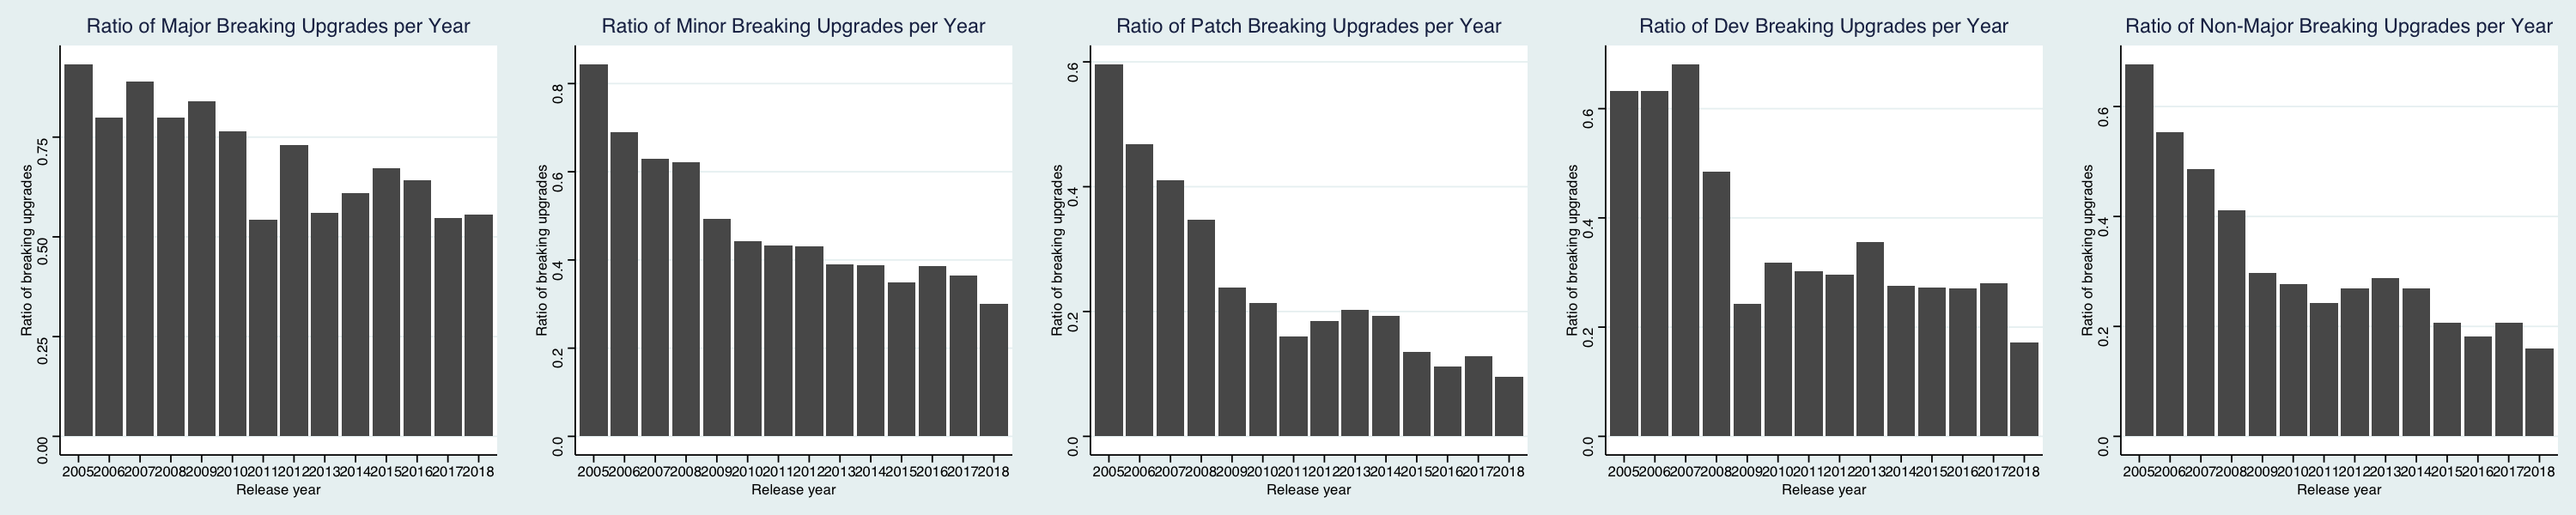

In [15]:
# Create histograms of the percentage of breaking upgrades per semver level
options(repr.plot.width=25, repr.plot.height=5)
bar_major <- plot_bar_semver("MAJOR", "Major")
bar_minor <- plot_bar_semver("MINOR", "Minor") 
bar_patch <- plot_bar_semver("PATCH", "Patch") 
bar_devs <- plot_bar_semver("DEV", "Dev")
bar_nonmajor <- plot_bar_semver("NONMAJOR", "Non-Major")
grid.arrange(bar_major, bar_minor, bar_patch, bar_devs, bar_nonmajor, ncol=5, nrow=1)

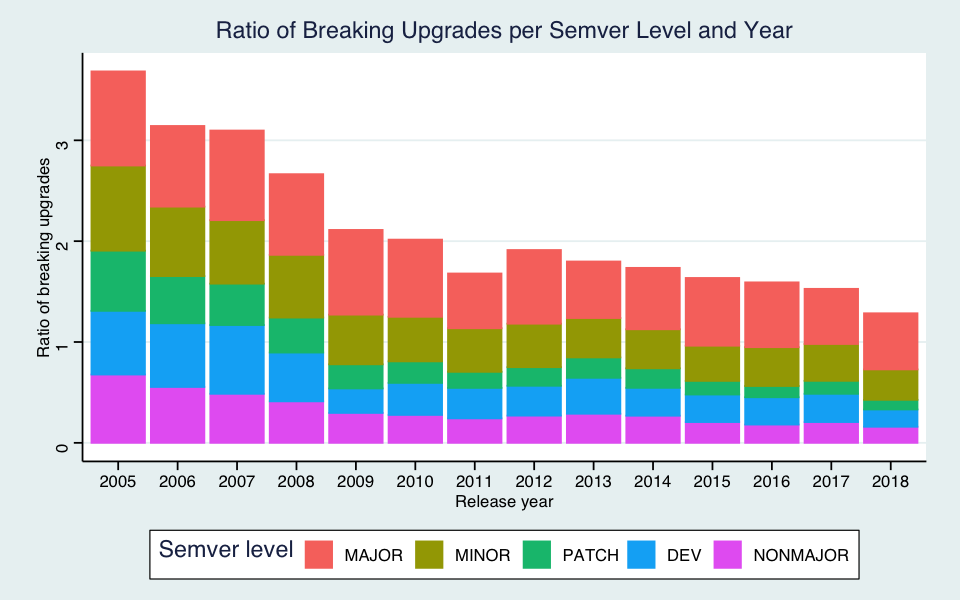

In [16]:
# A stacked view of the percentage of breaking upgrades per year per semver level
options(repr.plot.width=8, repr.plot.height=5)
ggplot(breaking_upgrades, aes(x=year, y=breaking, color=level, fill=level)) + 
        labs(title="Ratio of Breaking Upgrades per Semver Level and Year",
             x="Release year",
             y="Ratio of breaking upgrades",
             fill="Semver level", 
             color="Semver level") +
        geom_bar(stat="identity")

### Line Plot

Evolution of the ratio of breaking upgrades per semver level in MDG. Each data point aggregates the number of breaking upgrades of the given type for an entire year. A vertical line delimitates the periods of the original
and updated datasets.

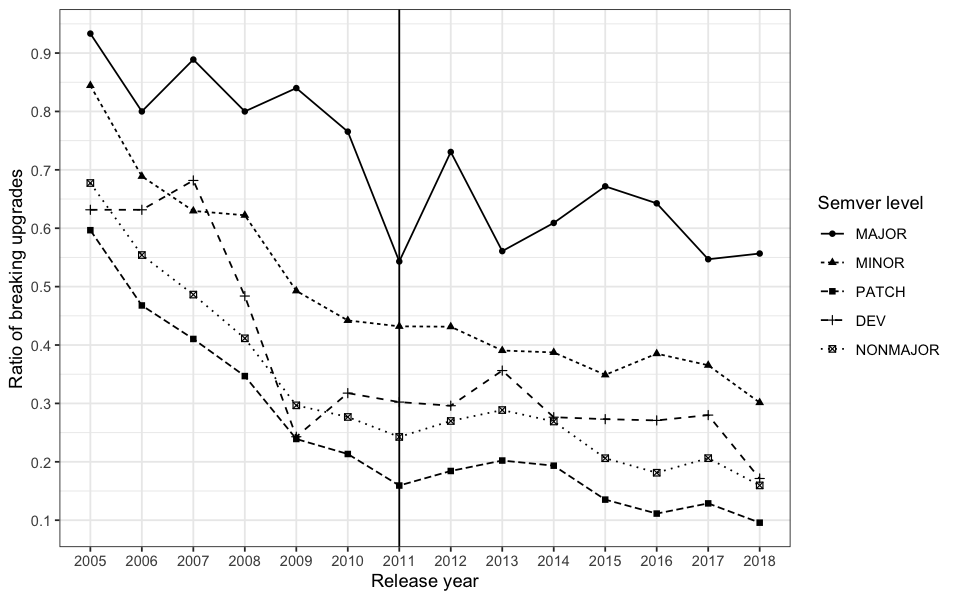

In [17]:
# Create line plot with the percentage of breaking upgrades per semver level per year
p <- ggplot(breaking_upgrades, aes(x=year, y=breaking, group=level)) + 
        geom_line(aes(linetype=level), stat="identity", size=0.5) +
        labs(x="Release year",
             y="Ratio of breaking upgrades",
             shape ="Semver level", 
             linetype="Semver level") +
        scale_y_continuous(breaks=seq(0,1,0.1)) +
        geom_vline(xintercept=7) + 
        geom_point(aes(shape=level)) +
        theme_bw()

p
ggsave("figures/mdg-semver-year.pdf", p,
       width=11, height=7)

---

## EOF

> Lina Ochoa, Thomas Degueule, Jean-Rémy Falleri & Jurgen Vinju. Breaking Bad? Semantic Versioning and Impact of Breaking Changes in Maven Central. Journal of Empirical Software Engineering, 2021.

This notebook—and all its content—is licensed under the [MIT License](https://choosealicense.com/licenses/mit/).   
© 2021 Maracas